<a href="https://colab.research.google.com/github/KeerHu73/linearModels/blob/main/lab/lab_notebook_applied.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hedonic Pricing

We often try to predict the price of an asset from its observable characteristics. This is generally called **hedonic pricing**: How do the unit's characteristics determine its market price?

In the lab folder, there are three options: housing prices in pierce_county_house_sales.csv, car prices in cars_hw.csv, and airbnb rental prices in airbnb_hw.csv. If you know of another suitable dataset, please feel free to use that one.

1. Clean the data and perform some EDA and visualization to get to know the data set.
2. Transform your variables --- particularly categorical ones --- for use in your regression analysis.
3. Implement an ~80/~20 train-test split. Put the test data aside.
4. Build some simple linear models that include no transformations or interactions. Fit them, and determine their RMSE and $R^2$ on the both the training and test sets. Which of your models does the best?
5. Make partial correlation plots for each of the numeric variables in your model. Do you notice any significant non-linearities?
6. Include transformations and interactions of your variables, and build a more complex model that reflects your ideas about how the features of the asset determine its value. Determine its RMSE and $R^2$ on the training and test sets. How does the more complex model your build compare to the simpler ones?
7. Summarize your results from 1 to 6. Have you learned anything about overfitting and underfitting, or model selection?
8. If you have time, use the sklearn.linear_model.Lasso to regularize your model and select the most predictive features. Which does it select? What are the RMSE and $R^2$? We'll cover the Lasso later in detail in class.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

url= "https://raw.githubusercontent.com/KeerHu73/linearModels/refs/heads/main/lab/data/airbnb_hw.csv"
df= pd.read_csv(url)
df.head()

,Host Id,Host Since,Name,Neighbourhood,Property Type,Review Scores Rating (bin),Room Type,Zipcode,Beds,Number of Records,Number Of Reviews,Price,Review Scores Rating
0,5162530,NaN,1 Bedroom in Prime Williamsburg,Brooklyn,Apartment,NaN,Entire home/apt,11249.0,1.0,1,0,145,NaN
1,33134899,NaN,"Sunny, Private room in Bushwick",Brooklyn,Apartment,NaN,Private room,11206.0,1.0,1,1,37,NaN
2,39608626,NaN,Sunny Room in Harlem,Manhattan,Apartment,NaN,Private room,10032.0,1.0,1,1,28,NaN
3,500,6/26/2008,Gorgeous 1 BR with Private Balcony,Manhattan,Apartment,NaN,Entire home/apt,10024.0,3.0,1,0,199,NaN
4,500,6/26/2008,Trendy Times Square Loft,Manhattan,Apartment,95.0,Private room,10036.0,3.0,1,39,549,96.0


Clean the data and perform EDA + visualization：

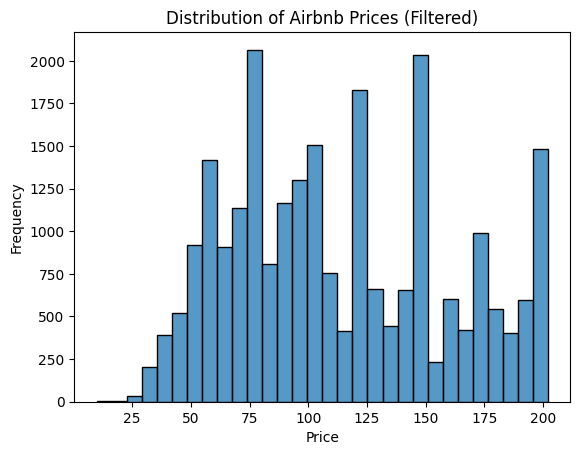

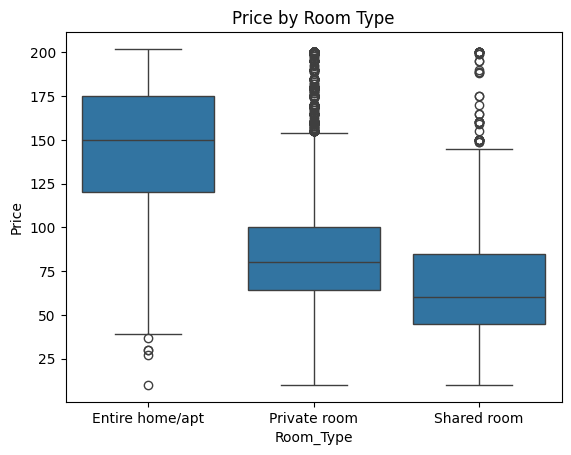

Top Neighbourhoods:
 Neighbourhood
Manhattan        11471
Brooklyn         10368
Queens            2154
Bronx              332
Staten Island      132
Name: count, dtype: int64
Top Property Types:
 Property_Type
Apartment          21776
House               1732
Loft                 527
Bed & Breakfast      166
Townhouse            101
Name: count, dtype: int64


In [7]:
# Standardize column names for easier use (remove spaces and unify format)
df.columns = df.columns.str.strip().str.replace(" ", "_")

# Then, convert target variable 'Price' to numeric
# Some price values might be strings or missing; coerce forces conversion to NaN if needed
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')

# Drop rows with missing target 'Price' or essential features
df = df.dropna(subset=['Price', 'Beds', 'Room_Type', 'Neighbourhood', 'Property_Type'])

#Filter out extreme prices (top 10%) to avoid distortion
q90 = np.quantile(df['Price'], 0.9)
df = df[df['Price'] < q90]

# Plot histogram of prices to visualize distribution
sns.histplot(df['Price'], bins=30)
plt.title("Distribution of Airbnb Prices (Filtered)")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

# Use boxplot to see how room type affects price since variables are categorical
sns.boxplot(data=df, x='Room_Type', y='Price')
plt.title("Price by Room Type")
plt.show()

# Step 1.8: Count top categories in Neighbourhood and Property_Type
print("Top Neighbourhoods:\n", df['Neighbourhood'].value_counts().head())
print("Top Property Types:\n", df['Property_Type'].value_counts().head())



2. Transform your variables — particularly categorical ones — for use in your regression analysis.
The goal is to convert categorical features into numerical form to facilitate the use of linear models. I'll adopt dummy variables next.

In [9]:
# First, select relevant categorical variables to transform
# Based on the EDA, these variables are potentially predictive
categorical_vars = ['Room_Type', 'Neighbourhood', 'Property_Type']

# Then, create dummy variables using one-hot encoding
# drop_first=True avoids multicollinearity by dropping the first category
df_encoded = pd.get_dummies(df, columns=categorical_vars, drop_first=True)

# Last, check resulting dataframe shape and column names
print("Encoded dataframe shape:", df_encoded.shape)
print("Encoded column examples:\n", df_encoded.columns[:10])


Encoded dataframe shape: (24457, 34)
Encoded column examples:
 Index(['Host_Id', 'Host_Since', 'Name', 'Review_Scores_Rating_(bin)',
       'Zipcode', 'Beds', 'Number_of_Records', 'Number_Of_Reviews', 'Price',
       'Review_Scores_Rating'],
      dtype='object')


3.  Implement an 80/20 train-test split. Put the test data aside.

In [11]:
# Frist, separate features and target
# The target variable is 'Price', all other columns are features
y = df_encoded['Price'].values  # Target: Price
X = df_encoded.drop(columns=['Price']).values  # Features: All other columns

# Then, create 80/20 train-test split using NumPy
# Set random seed for reproducibility
np.random.seed(42)
N = X.shape[0]  # Total number of observations
idx = np.random.permutation(N)  # Randomly permute indices

# Determine cutoff index
cutoff = int(0.8 * N)
train_idx = idx[:cutoff]
test_idx = idx[cutoff:]

# Split into train and test sets
X_train = X[train_idx, :]
X_test = X[test_idx, :]
y_train = y[train_idx]
y_test = y[test_idx]

# Last, confirm shapes of splits
print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)


Training data shape: (19565, 33)
Test data shape: (4892, 33)


4. Build simple linear models (no transformations or interactions):
Using the most basic linear model, without adding nonlinear terms or interaction terms, and only modeling with clean data.

The key point is calculation: Model coefficients (using the closed-form solution of OLS); predicted value; Performance metrics: RMSE and 𝑅2
